In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12), 'axes.grid': True, 'axes.facecolor': 'white', 'figure.facecolor': 'white', 'font.family': 'monospace'})
from PIL import Image
from collections import Counter
from multimodal.multimodal_data_module import MultiModalSAYCamDataModule
from multimodal.multimodal import TextEncoder, MultiModalModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import PAD_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID
from train import _setup_parser

from math import exp

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
# load model from checkpoint

parser = _setup_parser()
args = parser.parse_args("")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = MultiModalSAYCamDataModule(args)
data.prepare_data()
data.setup()

# select from list of checkpoints
checkpoint = [
    "checkpoints/lm_text_encoder_lstm_embedding_dim_32_tie_True_bias_True_dropout_i_0.0_dropout_o_0.1_batch_size_128_drop_last_True_optimizer_AdamW_lr_0.03_weight_decay_0.03_seed_0/epoch=12.ckpt",
    "checkpoints/lm_text_encoder_lstm_embedding_dim_32_tie_True_bias_True_dropout_i_0.0_dropout_o_0.1_batch_size_256_drop_last_True_optimizer_AdamW_lr_0.03_weight_decay_0.03_seed_0/epoch=8.ckpt",
    "checkpoints/lm_text_encoder_lstm_embedding_dim_32_tie_True_bias_True_dropout_i_0.0_dropout_o_0.1_batch_size_512_drop_last_True_optimizer_AdamW_lr_0.03_weight_decay_0.03_seed_1/epoch=16.ckpt",
    "checkpoints/lm_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.0_dropout_o_0.1_batch_size_8_drop_last_True_optimizer_AdamW_lr_0.003_weight_decay_0.03_seed_0/epoch=5.ckpt",
    "checkpoints/lm_text_encoder_cbow_embedding_dim_32_tie_False_bias_False_dropout_i_0.0_dropout_o_0.1_batch_size_128_drop_last_True_optimizer_AdamW_lr_0.01_weight_decay_0.04_seed_0/epoch=10.ckpt",

    "checkpoints/multimodal_sim_mean_embedding_type_spatial_text_encoder_embedding_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_False_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.0003_weight_decay_0.0_val_batch_size_16_seed_0/epoch=10.ckpt",
    "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.2_val_batch_size_16_seed_0/epoch=91.ckpt",

    "checkpoints/joint_lambda_mm_0.032_lambda_lm_1.0_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.003_weight_decay_0.05_val_batch_size_16_seed_0/last.ckpt",
    "checkpoints/joint_lambda_mm_0.1_lambda_lm_1.0_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.003_weight_decay_0.05_val_batch_size_16_seed_0/last.ckpt",
    "checkpoints/joint_lambda_mm_1.0_lambda_lm_1.0_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.003_weight_decay_0.05_val_batch_size_16_seed_0/last.ckpt",
][9]

print_dict_args = False
if print_dict_args:
    ckpt = torch.load(checkpoint)
    print(ckpt['hyper_parameters']['args'])

lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
print(lit_model.args)
lit_model.to(device)
text_encoder = lit_model.text_encoder

vocab = text_encoder.vocab
vocab_size = len(vocab)
print(f'vocab_size = {vocab_size}')
# check consistency between vocab and idx2word
for idx in range(vocab_size):
    assert idx in text_encoder.idx2word
lit_model.eval()

Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created . Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created . Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!
{'logger': True, 'checkpoint_callback': True, 'default_root_dir': None, 'gradient_clip_val': 0.0, 'gradient_clip_algorithm': 'norm', 'process_position': 0, 'num_nodes': 1, 'num_processes': 1, 'devices': None, 'gpus': 1, 'auto_select_gpus': False, 'tpu_cores': None, 'ipus': None, 'log_gpu_memory': None, 'progress_bar_refresh_rate': None, 'overfit_batches': 0.0, 'track_grad_norm': -1, 'check_val_every_n_epoch': 1, 'fast_dev_run': False, 'a

MultiModalLitModel(
  (vision_encoder): VisionEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [4]:
# get counts, vectors, losses, pos tags

from tqdm import tqdm
from nltk.tag import pos_tag

def get_sum_values(dataloader, get_value_level="vectors"):
    with torch.no_grad():
        cnt_pos = [Counter() for idx in range(vocab_size)]
        cnts = torch.zeros(vocab_size, dtype=torch.int, device=device)
        sum_vectors = torch.zeros(vocab_size, text_encoder.hidden_dim, device=device)
        sum_losses = torch.zeros(vocab_size, dtype=torch.float, device=device)

        for x, y, y_len in tqdm(dataloader):
            # pos tagging
            for i in range(y.size(0)):
                utterance_idxes = y[i, :y_len[i]].tolist()
                utterance_words = [text_encoder.idx2word[idx] for idx in utterance_idxes]
                tagging_indices, tagging_words = zip(*[(index, word) for index, word in enumerate(utterance_words) if word not in ['<sos>', '<eos>']])
                _, pos_tags = zip(*pos_tag(tagging_words))
                utterance_pos_tags = ['.'] * int(y_len[i])
                for index, pos in zip(tagging_indices, pos_tags):
                    utterance_pos_tags[index] = pos
                for idx, pos in zip(utterance_idxes, utterance_pos_tags):
                    cnt_pos[idx].update({pos: 1})

            y, y_len = y.to(device=device), y_len.to(device=device)
            if get_value_level == "vectors":
                outputs = text_encoder(y, y_len)
            elif get_value_level == "losses":
                loss, outputs, logits, labels = lit_model.language_model.calculate_ce_loss(y, y_len, tokenwise=True)
            cnts.index_add_(0, y.reshape((-1,)), torch.ones_like(y, dtype=torch.int).reshape((-1,)).detach())
            if get_value_level in ["vectors", "losses"]:
                sum_vectors.index_add_(0, y.reshape((-1,)), outputs.reshape((-1, outputs.size(-1))).detach())
            if get_value_level == "losses":
                sum_losses.index_add_(0, labels.reshape((-1,)), loss.reshape((-1,)).detach())

    return cnt_pos, cnts.cpu().numpy(), sum_vectors.cpu().numpy(), sum_losses.cpu().numpy()

# get sum values (counts, vector representations, losses) across the training set
cnt_pos, cnts, sum_vectors, sum_losses = get_sum_values(data.train_dataloader(), get_value_level="losses")
# get mean vectors
vectors = sum_vectors / np.expand_dims(cnts, -1)

# or directly use the embedding vectors
#vectors = text_encoder.embedding.weight.detach().cpu().numpy()

# set the POS tag of a word as the most frequent POS tag
pos_of_idx = [pos_counter.most_common(1)[0][0] if pos_counter else '.' for pos_counter in cnt_pos]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8289/8289 [01:09<00:00, 118.61it/s]
/tmp/ipykernel_24248/4236592169.py:42: RuntimeWarning: invalid value encountered in true_divide
  vectors = sum_vectors / np.expand_dims(cnts, -1)


In [5]:
# print utilities

idx_formatter = lambda i: f'{text_encoder.idx2word[i]:<10} {pos_of_idx[i]:<4} {cnts[i]:6}'
get_ppl = lambda cnt, loss: exp(loss / cnt)

def print_perplexities(losses_list, print_indices):
    losses = list(zip(*losses_list))

    formatter = lambda prefix, values: f'{prefix:<22}: ' + ' '.join(f'{value:9.3f}' for value in values)
    for i in print_indices:
        print(formatter(idx_formatter(i), (get_ppl(cnts[i], loss) for loss in losses[i])))

    print()

    tot, tot_loss_ = 0, [0. for j in range(len(losses_list))]

    def add_token_contribution(tot, tot_loss_, token_id, weight=+1):
        return tot + weight * cnts[token_id], [tot_loss + weight * loss for tot_loss, loss in zip(tot_loss_, losses[token_id])]

    for i in range(0, vocab_size):
        if i not in [PAD_TOKEN_ID]:
            tot, tot_loss_ = add_token_contribution(tot, tot_loss_, i)

    tot_ppl_formatter = lambda prefix: formatter(prefix, (get_ppl(tot, tot_loss) for tot_loss in tot_loss_))
    print(tot_ppl_formatter('ppl'))

    tot, tot_loss_ = add_token_contribution(tot, tot_loss_, SOS_TOKEN_ID, -1)
    print(tot_ppl_formatter('ppl_wo_sos'))

    tot, tot_loss_ = add_token_contribution(tot, tot_loss_, EOS_TOKEN_ID, -1)
    print(tot_ppl_formatter('ppl_wo_sos_eos'))

    print()


print_perplexities([sum_losses], range(20))

seed_0_losses = sum_losses
#print_perplexities([lstm_losses, cbow_losses], range(20))
#print_perplexities([seed_0_losses, seed_1_losses], range(20))

<pad>      .    146001:     1.000
<unk>      NN      294:   217.494
<sos>      .     33155:     1.000
<eos>      .     32888:     2.223
alright    NN      645:    96.203
lets       NNS     126:   348.708
change     VB       58:   128.081
your       PRP$   1590:    12.595
nappy      JJ      126:     8.997
though     IN      121:   132.375
first      RB      106:   437.430
yeah       NN     4849:     9.503
oh         UH     1250:    35.674
you        PRP    8544:     6.528
wanna      VBP     291:    47.491
do         VBP    1830:    28.790
it         PRP    3467:    10.929
i          NN     2300:    30.009
think      VBP     531:    18.058
there      EX     1905:    31.263

ppl                   :    15.325
ppl_wo_sos            :    24.047
ppl_wo_sos_eos        :    38.329



In [6]:
# cosine matrices for some tested words

np.set_printoptions(precision=2, suppress=True)

# cosine matrices
for inp in [
    "red orange yellow green blue purple brown black white",
    "boy girl mommy daddy grandpa grandma",
]:
    print('words:', inp)
    tokens = inp.split()
    token_ids = []
    print('not found:', end='')
    for s in tokens:
        try:
            token_ids.append(text_encoder.word2idx[s])
        except KeyError:
            print(f' {s}')
    print()

    V = vectors[token_ids]
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    print('pairwise cosine:')
    print(V @ V.T)

# cosine matrices for the differentiations (vector1 - vector0)
for inp in [
    "do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives",
    "do did go went play played get got eat ate have had make made look looked fly flew drive drove stand stood crawl crawled",
    "do doing go going play playing get getting eat eating have having look looking fly flying drive driving stand standing crawl crawling",
    "do don't does doesn't did didn't should shouldn't has hasn't have haven't will won't",
    "boy girl mommy daddy grandpa grandma",
]:
    print('words:', inp)
    tokens = inp.split()
    assert len(tokens) % 2 == 0
    token_ids = []
    ok = True
    print('not found:', end='')
    for s in tokens:
        try:
            token_ids.append(text_encoder.word2idx[s])
        except KeyError:
            print(f' {s}')
            ok = False
    print()
    if ok:
        V = vectors[token_ids]
        V = V.reshape((V.shape[0] // 2, 2,) + V.shape[1:])
        V = V[:, 1] - V[:, 0]
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        print('pairwise cosine of vectors:')
        print(V @ V.T)

words: red orange yellow green blue purple brown black white
not found:
pairwise cosine:
[[1.   0.53 0.78 0.83 0.77 0.71 0.66 0.65 0.62]
 [0.53 1.   0.52 0.5  0.48 0.49 0.38 0.55 0.41]
 [0.78 0.52 1.   0.88 0.82 0.77 0.68 0.73 0.71]
 [0.83 0.5  0.88 1.   0.85 0.77 0.69 0.72 0.77]
 [0.77 0.48 0.82 0.85 1.   0.72 0.67 0.73 0.7 ]
 [0.71 0.49 0.77 0.77 0.72 1.   0.67 0.65 0.7 ]
 [0.66 0.38 0.68 0.69 0.67 0.67 1.   0.7  0.58]
 [0.65 0.55 0.73 0.72 0.73 0.65 0.7  1.   0.66]
 [0.62 0.41 0.71 0.77 0.7  0.7  0.58 0.66 1.  ]]
words: boy girl mommy daddy grandpa grandma
not found:
pairwise cosine:
[[1.   0.78 0.37 0.13 0.33 0.31]
 [0.78 1.   0.39 0.09 0.4  0.35]
 [0.37 0.39 1.   0.1  0.59 0.6 ]
 [0.13 0.09 0.1  1.   0.03 0.1 ]
 [0.33 0.4  0.59 0.03 1.   0.74]
 [0.31 0.35 0.6  0.1  0.74 1.  ]]
words: do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives
not found:
pairwise cosine of vectors:
[[ 1.    0.12  0.04  0.02  0.14  0.14  0.19  0.11  0.13 -0.06]

In [7]:
# select words with frequency threshold; the threshold must be larger than 0, since we must not select untrained vectors
selected = cnts >= 100
selected[PAD_TOKEN_ID] = False
selected_indices = np.arange(len(vectors))[selected]
n_samples = len(selected_indices)
print('number of filtered words:', n_samples)

selected_vectors = vectors[selected] # for linkage clustering

# check some selected words
for i in selected_indices[:50]:
    print(idx_formatter(i))
print()
for word in ['need', 'draw']:
    print(idx_formatter(text_encoder.word2idx[word]))

number of filtered words: 222
<unk>      NN      294
<sos>      .     33155
<eos>      .     32888
alright    NN      645
lets       NNS     126
your       PRP$   1590
nappy      JJ      126
though     IN      121
first      RB      106
yeah       NN     4849
oh         UH     1250
you        PRP    8544
wanna      VBP     291
do         VBP    1830
it         PRP    3467
i          NN     2300
think      VBP     531
there      EX     1905
might      MD      141
be         VB      404
some       DT      974
pretty     RB      169
have       VBP    1532
to         TO     4452
draw       VB      109
on         IN     1711
want       VBP    2775
that       DT     2016
ok         NN      811
let's      NN      679
find       VB      118
shoes      NNS     155
sam        NN      461
where      WRB     415
are        VBP    1962
this       DT     1370
up         RP      570
so         RB      555
all        DT     1145
off        RP      351
we         PRP    2757
can        MD     1781
eat 

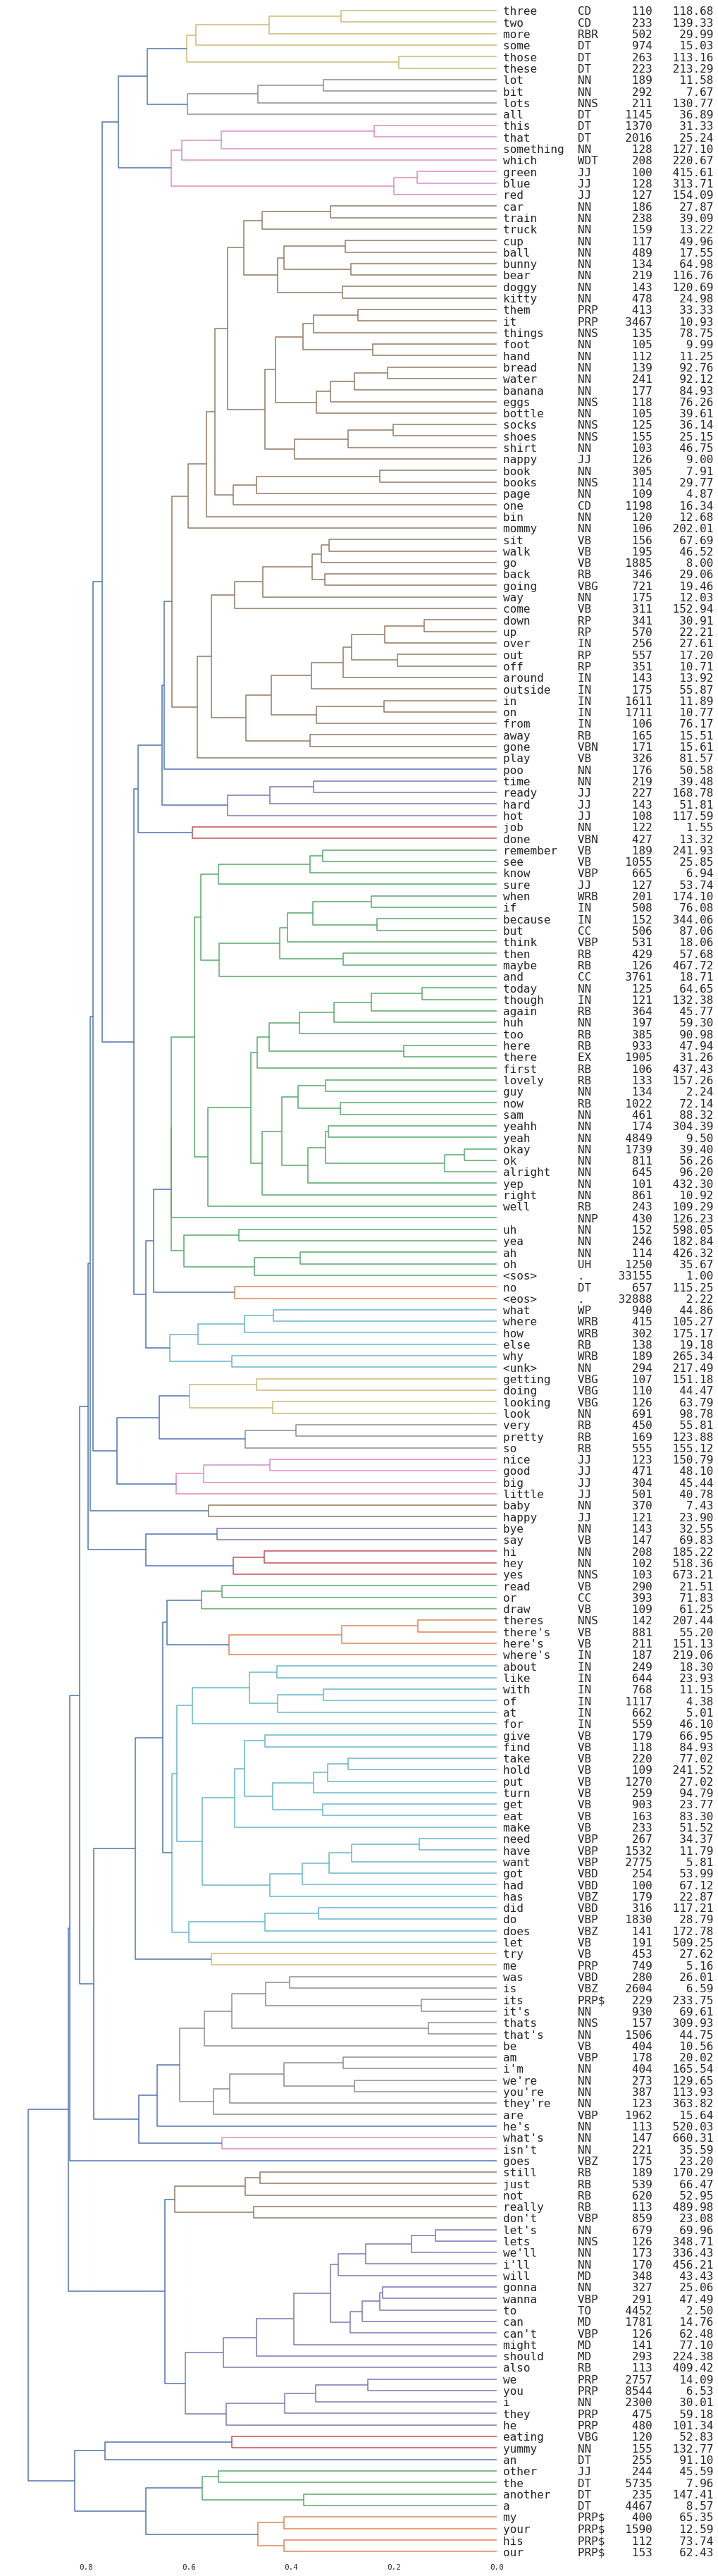

In [8]:
# linkage clustering and dendrogram plotting

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(selected_vectors, method='average', metric='cosine')  # of shape (number of merges = n_samples - 1, 4)

def llf(index):
    if index < n_samples:
        idx = selected_indices[index]
        _ppl = lambda loss: get_ppl(cnts[idx], loss)
        return idx_formatter(idx) + f' {_ppl(sum_losses[idx]):8.2f}' # f' {_ppl(seed_1_losses[idx]):8.2f}{(_ppl(seed_2_losses[idx]) - _ppl(seed_1_losses[idx]):+8.2f}'
    else:
        merge_index = index - n_samples
        return f'{merge_index} {int(Z[merge_index, 3])} {Z[merge_index, 2]:.3f}'

p = 10000

plt.figure(figsize=(25 / 2, 0.3 * min(p, n_samples))) # 0.1
_ = dendrogram(
    Z,
    truncate_mode='lastp',
    p=p,
    orientation='left',
    leaf_rotation=0.,
    leaf_font_size=16.,
    leaf_label_func=llf,
)

/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


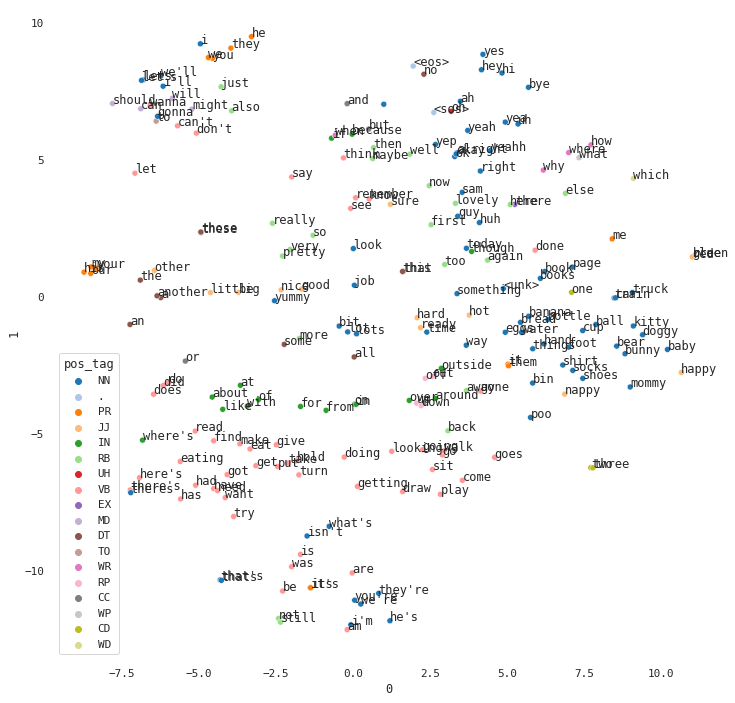

In [9]:
# t-SNE

from sklearn.manifold import TSNE
def get_coordinates(vectors):
    tsne = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate='auto', n_iter=1000, metric='cosine')
    points = tsne.fit_transform(vectors)
    return points
points = get_coordinates(selected_vectors)

# plotting
def pos_mapping(pos):
    pos = pos[:2]
    return pos
#plt.scatter(points[:, 0], points[:, 1], s=10)
df = pd.DataFrame(points)
df['word'] = [text_encoder.idx2word[idx] for idx in selected_indices]
df['pos_tag'] = [pos_mapping(pos_of_idx[idx]) for idx in selected_indices]
sns.scatterplot(data=df, x=0, y=1, hue='pos_tag', palette='tab20')
for idx, point in zip(selected_indices, points):
    plt.text(point[0], point[1], text_encoder.idx2word[idx])